# import

In [1]:

import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
from my_library.library import *
from pprint import pprint
import json
import requests
import sys
path_ =  '/Users/Owner/Desktop/coincheck_api'
sys.path.append(path_)
from settings_coincheck import API_settings as capi
import ccxt
import datetime
import logging
from pprint import pprint
import json
import requests
import time
from logging import getLogger,Formatter, StreamHandler, FileHandler, DEBUG, INFO
import math
%load_ext autoreload

# API KEY

In [2]:

API_KEY = capi.API_KEY
API_SECRET = capi.API_SECRET
coincheck = ccxt.coincheck({'apiKey':API_KEY,'secret':API_SECRET})


# 定数

In [3]:



# 交換する通貨のペア
SYMBOL = "BTC/JPY"

# 最適指値の計算に用いる, 注文数量の閾値
SIZE_THRU = 0.05

# 取引するBTCの数量
# 今回はcoincheckの最小取引数量とした
BTC_AMOUNT = 0.005

# スプレッドの閾値
# SPREAD = 0.00044
# 土日はspread小さい
# 未実装
# spread = return_spread()
SPREAD = 0.00050

# 変化率の閾値
# 変化率の大きい相場では取引しない
PCT_RATE = 0.0006

# 乖離率の閾値
# 乖離率1％を超えると損切
DEVIATION_RATE = 0.01

# 指値更新の値幅, 2円ずつ更新
DP = 4

# 最適指値で約定しなかった際, 1円の利益で妥協するための差分
DELTA = 400

# ローソク足の時間間隔
MIN_WIDTH = '5m'

# 何分約定しなかったら損切スタートさせるか決める定数
LOOP_COUNT = 400

# 強制損切注文を出すまでのカウント
FORCE_LOOP_COUNT = LOOP_COUNT * 4

# LINE notify のapi利用に必要なトークン
TOKEN = capi.TOKEN

# 買いやすさ, 売りやすさを決めるバイアス
# 上がり基調 -> TRADE_BIAS>0
# 下がり基調 -> TRADE_BIAS<0
# TRADE_BIAS > 0 で買いやすい => buy_price が低く, sell_price が高くなる
# TRADE_BIAS < 0 で売りやすい => buy_price が高く, sell_price が低くなる
TRADE_BIAS = 0.00
BUY_BIAS = (1-TRADE_BIAS)
SELL_BIAS = (1+TRADE_BIAS)

# ボラティリティが大きい相場で, どれだけ様子見するか
# 単位は[s]
SLEEP_TIME = 240

# 許容できる損失
# 単位 [円]
TOLERABLE_LOSS = 10

# funcs

In [17]:




#　取引通貨情報
def market_info():
    result = coincheck.load_markets()
    return result

# 板情報を取得する関数
def OrderBook():
    result = coincheck.fetchOrderBook(symbol=SYMBOL)
    return result

# 売り注文と買い注文を取得する関数
def ticker_info():
    result = coincheck.fetch_ticker(symbol=SYMBOL)
    return result

# 口座情報を取得する関数
def balance_info():
    result = coincheck.fetchBalance()
    return result

# 今出している注文をキャンセルする関数
# order_id は OpenOrder関数から取得可能
def OrderCancel(order_id):
    result = coincheck.cancel_order(
            symbol = SYMBOL,  # 取引通貨
            id = order_id,    # 注文ID
            )
    return result

# 今出している注文を取得する関数
def OpenOrder():
    result = coincheck.fetchOpenOrders(symbol = SYMBOL)
    return result

# 買い注文を出す関数
def buy(price_value, btc_amount=0.005):
    order_symbol = 'BTC/JPY'   # 取引通貨
    type_value   = 'limit'     # 注文タイプ（limit:指値注文, market:成行注文）
    side_value   = 'buy'       # 買い(buy) or 売り(sell)

    # 注文コード
    order = coincheck.create_order(
                    symbol = order_symbol,  # 取引通貨
                    type = type_value,      # 注文タイプ
                    side= side_value,       # 買 or 売
                    amount= btc_amount,   # 取引数量
                    price=price_value,      # 指値価格
                    )
    return  order

# 買い注文を出す関数
def buy_market(price_value, btc_amount=0.005):
    order_symbol = 'BTC/JPY'   # 取引通貨
    type_value   = 'market'     # 注文タイプ（limit:指値注文, market:成行注文）
    side_value   = 'buy'       # 買い(buy) or 売り(sell)

    # 注文コード
    order = coincheck.create_order(
                    symbol = order_symbol,  # 取引通貨
                    type = type_value,      # 注文タイプ
                    side= side_value,       # 買 or 売
                    amount= btc_amount,   # 取引数量
                    price=price_value,      # 指値価格
                    )
    return  order

# 売り注文を出す関数
def sell(price_value,btc_amount=0.005):
    order_symbol = 'BTC/JPY'   # 取引通貨
    type_value   = 'limit'     # 注文タイプ（limit:指値注文, market:成行注文）
    side_value   = 'sell'       # 買い(buy) or 売り(sell)

    # 注文コード
    order = coincheck.create_order(
                    symbol = order_symbol,  # 取引通貨
                    type = type_value,      # 注文タイプ
                    side= side_value,       # 買 or 売
                    amount= btc_amount,   # 取引数量
                    price=price_value,      # 指値価格
                    )
    return  order
    
# 売り注文を出す関数
def sell_market(price_value,btc_amount=0.005):
    order_symbol = 'BTC/JPY'   # 取引通貨
    type_value   = 'market'     # 注文タイプ（limit:指値注文, market:成行注文）
    side_value   = 'sell'       # 買い(buy) or 売り(sell)

    # 注文コード
    order = coincheck.create_order(
                    symbol = order_symbol,  # 取引通貨
                    type = type_value,      # 注文タイプ
                    side= side_value,       # 買 or 売
                    amount= btc_amount,   # 取引数量
                    price=price_value,      # 指値価格
                    )
    return  order

# 買い注文, 売り注文が約定したかどうか把握する関数
# is_buy : True -> 買い注文約定
# is_sell : True -> 売り注文約定
def get_status(sell_amount):
    symbol = 'BTC/JPY'
    order_now = OpenOrder()
    b_info = balance_info()
    free = float(b_info['free']['BTC'])
    used = float(b_info['used']['BTC'])
    total = float(b_info['total']['BTC'])
    is_buy = False
    is_sell = False   

    # freeがBTC_AMOUT以下になる　つまり, 一部しか約定しない時があるならば, usedも0にならない時があるのでは?
    # freeが取引する数量の2倍以上はerrorの元なので, 通さない
    # Rate limit error : 売り注文の時しかでない？
    if len(order_now)==0 and used==0 and 0<free<BTC_AMOUNT*2:
        is_buy = True
        is_sell = True
        logger.info('here 1')
        
    # Rate limit error の時
    elif len(order_now)==0 and used==0 and free%BTC_AMOUNT==0 and free>=BTC_AMOUNT*2:
        is_buy=True
        is_sell = False
        logger.info('here 2')
        time.sleep(5)
        
    elif len(order_now)==0 and used==0 and free >= BTC_AMOUNT*2:
        is_buy=True
        is_sell = False
        logger.info('here 3')
        time.sleep(5)
    
    elif len(order_now)==0 and used>0:
        is_buy=True
        is_sell = False
        logger.info('here 4')
        time.sleep(5) 
        
    elif len(order_now)==1 :
        side = order_now[0]['side']
        if side == 'buy':
            is_sell = True
        elif side == 'sell':
            is_buy = True
        logger.info('here 5')
            
    elif len(order_now)==2 and used==sell_amount and free==0:
        is_buy = False
        is_sell = False 
    
    elif len(order_now)==2:
        side0 = order_now[0]['side']
        side1 = order_now[1]['side']
        
        if side0==side1=='buy' or side0==side1=='sell':
            # 古いほうの買い注文キャンセルしたい
            # 0 が古いほう
            if side0=='buy':logger.info('Two buy order')
            if side0=='sell':logger.info('Two sell order')
            
            old_order = order_now[0]['id']
            try:
                order_cancel = OrderCancel(old_order)
            except Exception as e:
                logger.info(e)
                logger.info('Cant cancel in get_status')
        
        else:
            logger.info('Buy and Sell order')
            logger.info('free {0}'.format(free))
            logger.info('used {0}'.format(used))
            
    elif len(order_now)==0 and used==0 and free==0:
        # free 持っている btc_amount
        # used 注文に出している btc_amount
        is_buy = False
        is_sell = True
        logger.info('here 6')
    
    else:
        logger.info('default')
        logger.info('free {0}'.format(free))
        logger.info('used {0}'.format(used))
        logger.info('order length :{0}'.format(len(order_now)))
        time.sleep(1)
        
    return is_buy, is_sell

# 板情報から最適な指値を計算する関数
def calc_best_price(size_thru=SIZE_THRU,buy_bias=BUY_BIAS,sell_bias=SELL_BIAS):
    orderbook = OrderBook()
    ask_list = orderbook['asks']
    bid_list = orderbook['bids']

    i = 0
    b_amount = 0
    while b_amount<=size_thru*BUY_BIAS:
        b_amount += bid_list[i][1]
        buy_price = bid_list[i][0]
        i+=1
        
    i=0
    a_amount = 0
    while a_amount<=size_thru*SELL_BIAS:
        a_amount += ask_list[i][1]
        sell_price = ask_list[i][0]
        i+=1
        
    ask = ask_list[0][0]
    bid = bid_list[0][0]
    
    return ask,bid,buy_price,sell_price

# ローソク足を取得する関数
def return_candles(min_='15m'):
    candles = coincheck.fetch_ohlcv(
        symbol=SYMBOL,     # 暗号資産[通貨]
        timeframe = min_,    # 時間足('1m', '5m', '1h', '1d')
        since=None,           # 取得開始時刻(Unix Timeミリ秒)
        limit=None,           # 取得件数(デフォルト:100、最大:500)
        params={}             # 各種パラメータ
        )
    return candles

# ローソク足からボラティリティを計算する関数
def calc_pct_rate(candles):
    open_ = candles[0][1]
    high_ = candles[0][2]
    low_ = candles[0][3]
    close_ = candles[0][4]
    volume_ = candles[0][5]
    
    pct_rate = (open_-close_)/close_
    return pct_rate, volume_

# LINE に通知する関数
def send_line_notify(message):
    """
    LINEに通知する
    """
    line_notify_token = TOKEN
    line_notify_api = 'https://notify-api.line.me/api/notify'
    headers = {'Authorization': f'Bearer {line_notify_token}'}
    data = {'message': f'message: {message}'}
    requests.post(line_notify_api, headers = headers, data = data)
    
# 注文した値段と, 相場の価格の乖離率を計算する関数
def calc_deviation_rate(price):
    result = ticker_info()
    last_price = float(result['last'])
    dev_rate = np.abs((last_price - price) / price)
    return dev_rate

# 買いやすさ, 売りやすさを調整する関数
def return_trade_bias(pct_rate):
    trade_bias = 0

    if pct_rate>0:
        trade_bias = 100*np.tanh(pct_rate)
    elif pct_rate<0:
        trade_bias = 100*np.tanh(pct_rate)
    else:
        trade_bias = 0
        
    if np.abs(trade_bias)>=0.015:
        if trade_bias>0:
            trade_bias = 0.015
        else:
            trade_bias = -0.015
        
    return trade_bias

# spread を調整する関数
# 未実装
def return_spread(pct_rate,trade_freq,candles_hour):
    volume = candles_hour[0][5]
    spread = 0
    return spread

# 注文いれなおしたり, キャンセルする関数定義
def cancel_order(order_id):
    pass


# 指値更新の関数
# 段階損切なら, DP
# 様子見指値更新なら DELTA
def update_index_price(side,order_now,old_price,trade_amount,losscut_price):
    
    is_error = False
    is_rate_limit = False
    
    if side=='sell':            
        order_func = sell
    
    else:    # buy            
        order_func = buy
    
    price_tmp = old_price + losscut_price
    
    try:
        order_id = order_now[0]['id']
        order_cancel = OrderCancel(order_id)
        time.sleep(0.5)
        order_ = order_func(price_tmp,btc_amount=trade_amount)
        current_price = price_tmp
        return current_price, order_, is_error, is_rate_limit
        
    except Exception as e:
        is_error = True
        b_info = balance_info()
        free = float(b_info['free']['BTC'])
        
        # rate limit だった時   
        if free>=BTC_AMOUNT*2 and side=='sell':
            logger.info('Rate limit')
            is_rate_limit = True
            time.sleep(5)
        else:
            logger.info('in Update '+side)
            logger.info(e)
        
        return price_tmp, None, is_error, is_rate_limit
    
def is_buyable(short_line, long_line,index_):
    long_is_upper = long_line.iloc[index_-1]>short_line.iloc[index_-1]
    long_is_lower = long_line.iloc[index_]<=short_line.iloc[index_]
    
    # 移動平均線の微分係数が正であるか確認する
    long_diff_coef = differantiate_sum(long_line)
    short_diff_coef = differantiate_sum(short_line) 
    is_long_plus = False
    is_short_plus = False
    
    if long_diff_coef>0:
        is_long_plus=True
    
    if short_diff_coef>0:
        is_short_plus=True 
    
    buyable = long_is_upper and long_is_lower and is_long_plus and is_short_plus
    return buyable

def is_sellable(short_line, long_line,index_):
    long_is_lower = long_line.iloc[index_-1]<short_line.iloc[index_-1]
    long_is_upper = long_line.iloc[index_]>=short_line.iloc[index_]
    # 短期移動平均線の勾配が 0以下か確認
    short_coef = differentiate(short_line)
    is_grad_zero = False
    if short_coef<=0:
        is_grad_zero = True
    
    sellable = (long_is_upper and long_is_lower) or is_grad_zero
    return sellable

def differantiate_sum(line_):
    coefficient_ = line_.tail().diff().iloc[-4:].sum()
    return coefficient_

def differentiate(line_):
    coefficient_ = line_.tail().diff().iloc[-1]
    return coefficient_

# 単発買い注文

In [ ]:

symbol = 'BTC/JPY'
board = ticker_info()
buy_price = board['bid'] + 1
buy_price

In [ ]:
symbol = 'BTC/JPY'
board = ticker_info()

buy_price = board['bid'] + 1
sell_price = board['ask'] - 1

order_buy = buy(2331173.0)

In [5]:
OpenOrder()

[]

# 単発売り注文

In [ ]:
balance_info()

In [ ]:
symbol = 'BTC/JPY'
board = ticker_info()

buy_price = board['bid'] + 1
# sell_price = board['ask'] - 1
sell_price = 2339455.0

btc_amount = 0.005
order_sell = sell(sell_price,btc_amount= BTC_AMOUNT)

# order cancel

In [5]:
OpenOrder()

[]

In [ ]:
# order_id = order_buy['id']
order_cancel = OrderCancel(5147984578)

# Log の設定


In [6]:


#------------------------------------------------
# ログの出力名の設定
logger = getLogger('LoggingTest')
#　ログレベルの設定
logger.setLevel(10)
# ログのファイル出力先を設定
file_name = datetime.datetime.now().strftime('%Y%m%d') + '_' + datetime.datetime.now().strftime('%H%M%S')+'.log'
# 設定してください
path_log = '/Users/Owner/Desktop/BitCoin/Log/'
fh = FileHandler(path_log+file_name)
logger.addHandler(fh)

# ログの出力形式の設定
formatter = logging.Formatter('%(asctime)s:%(lineno)d:%(levelname)s:%(message)s')
fh.setFormatter(formatter)
#------------------------------------------------

send_line_notify('Trade start')

logger.info('Trade Start')
logger.info('SYMBOL             {0}'.format(SYMBOL))
logger.info('SIZE_THRU          :{0}'.format(SIZE_THRU))
logger.info('BTC_AMOUT          :{0}'.format(BTC_AMOUNT))
logger.info('SPREAD              :{0}'.format(SPREAD))
logger.info('PCT_RATE           :{0}'.format(PCT_RATE))
logger.info('DEVIATION RATE     :{0}'.format(DEVIATION_RATE))
logger.info('DP                 :{0}'.format(DP))
logger.info('DELTA              :{0}'.format(DELTA))
logger.info('MIN_WIDTH          :{0}'.format(MIN_WIDTH))
logger.info('LOOP_COUNT         :{0}'.format(LOOP_COUNT))
logger.info('FORCE_LOOP_COUNT   :{0}'.format(FORCE_LOOP_COUNT))
logger.info('SLEEP_TIME         :{0}'.format(SLEEP_TIME))


# 売買システム　コード

In [7]:



trade_count = 0
profit = 0
total_profit = 0
pos = 'none'
remain_btc = float(balance_info()['info']['btc'])
jpy_before = float(balance_info()['info']['jpy'])

while True:
    try:
        
        if pos=='none':
            
            # ローソク足取得 (60分単位)
            candles_hour = return_candles(min_='60m')
            
            # trade_bias 計算用
            pct_rate_for_bias,volume_hour = calc_pct_rate(candles_hour)
            
            # 相場状況によって, 買いやすさ, 売りやすさを決めるバイアスを計算する
            trade_bias = return_trade_bias(pct_rate_for_bias)
            buy_bias = (1-trade_bias)
            sell_bias = (1+trade_bias)
            
            # 最適な指値計算
            ask,bid,buy_price,sell_price = calc_best_price(size_thru=SIZE_THRU,\
                buy_bias=buy_bias, sell_bias=sell_bias)
            
            # 注文板の開き具合を計算
            spread = (ask-bid)/bid
            
            # 指値更新フラグを初期化
            change_index_flag = False
            
            # 損切のための変数初期化
            loop_count = 0
            
            # ローソク足取得 (5分単位)
            candles = return_candles(min_=MIN_WIDTH)
            
            # ローソク足から, 相場の変化率を計算
            pct_rate,volume_ = calc_pct_rate(candles)

            # 乖離率初期化
            dev_rate = 0
            
            # Rate limit error 対策
            is_rate_limit = False
            
            # 日本円計算用
            jpy_pre = float(balance_info()['info']['jpy'])
            
            # 変化率が大きい相場では取引するのが危ないので, 15分間取引しない
            if np.abs(pct_rate) >= PCT_RATE:
                logger.info('High volatility detected, sleep for a while.')
                time.sleep(SLEEP_TIME)
                
            # 取引数量が少ない時に買い増しする
            if remain_btc<BTC_AMOUNT:
                logger.info('Low amount2')
                logger.info('remain_btc {0}'.format(remain_btc))
                order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                time.sleep(1)
                order_now = OpenOrder()
                remain_btc = float(balance_info()['info']['btc'])
                
                if len(order_now)>1:
                    id = order_now[0]['id']
                    order_cancel = OrderCancel(id)
                    
                time.sleep(1)
                # 取引数量に満たない場合は買い増しする
                while remain_btc<BTC_AMOUNT:
                    logger.info('order id length {0}'.format(len(order_now)))
                    
                    if len(order_now)==2:
                        side0 = order_now[0]['side']
                        side1 = order_now[1]['side']
                        
                        if side0==side1=='buy' or side0==side1=='sell':
                            # 古いほうの買い注文キャンセルしたい
                            # 0 が古いほう
                            if side0=='buy':logger.info('Two buy order1')
                            if side0=='sell':logger.info('Two sell order1')
                            
                            old_order = order_now[0]['id']
                            try:
                                order_cancel = OrderCancel(old_order)
                            except Exception as e:
                                logger.info(e)
                                logger.info('Cant cancel in pre entry')
                                
                        else:
                            
                            if side0=='buy':
                                buy_order = order_now[0]['id']
                                try:
                                    order_cancel = OrderCancel(buy_order)
                                except Exception as e:
                                    logger.info(e)
                                    logger.info('Cant cancel in pre entry0')
                            elif side1=='buy':
                                buy_order = order_now[0]['id']
                                try:
                                    order_cancel = OrderCancel(buy_order)
                                except Exception as e:
                                    logger.info(e)
                                    logger.info('Cant cancel in pre entry1')
                    
                    try:
                        order_id = order_now[0]['id']
                        order_cancel = OrderCancel(order_id)
                        time.sleep(1)
                    except Exception as e:
                        logger.info(e)
                        break
                    
                    ask,bid,buy_price,sell_price = calc_best_price(size_thru=SIZE_THRU)
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    time.sleep(1)
                    order_now = OpenOrder()
                
                time.sleep(1)
                remain_btc = float(balance_info()['info']['btc'])
        
            # spread が十分大きいかつ, 変化率が許容範囲
            if spread >= SPREAD and np.abs(pct_rate) < PCT_RATE:
                logger.info("-------------------")
                
                # 注文数量が残った時,　前回の数量を上乗せして発注する
                if remain_btc>BTC_AMOUNT:
                    sell_amount = remain_btc
                    order_sell = sell(sell_price,btc_amount=sell_amount)
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    logger.info('Over amount')
                    logger.info('sell amount {0}'.format(sell_amount))
                    logger.info('entry')
                    logger.info('sell_price {0}'.format(sell_price))
                    logger.info('buy_price  {0}'.format(buy_price))
                    pos = 'entry'
                    
                # 在庫が最小取引単位を下回ったら買い増ししなけらばならない
                elif remain_btc<BTC_AMOUNT:
                    logger.info('Low amount1')
                    logger.info('remain_btc {0}'.format(remain_btc))
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    time.sleep(1)
                    order_now = OpenOrder()
                    remain_btc = float(balance_info()['info']['btc'])
                    
                    if len(order_now)>1:
                        id = order_now[0]['id']
                        order_cancel = OrderCancel(id)
                        
                    # 取引数量に満たない場合は買い増しする
                    while remain_btc<BTC_AMOUNT:
                        logger.info('order id length {0}'.format(len(order_now)))
                        
                        try:
                            order_id = order_now[0]['id']
                            order_cancel = OrderCancel(order_id)
                            time.sleep(1)
                        except Exception as e:
                            logger.info(e)
                            break
                        
                        ask,bid,buy_price,sell_price = calc_best_price(size_thru=SIZE_THRU)
                        order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                        time.sleep(1)
                        order_now = OpenOrder()
                    
                    time.sleep(1)
                    remain_btc = float(balance_info()['info']['btc'])
                
                # 正常な取引数量の時   
                elif remain_btc==BTC_AMOUNT:
                    sell_amount = BTC_AMOUNT
                    order_sell = sell(sell_price,btc_amount=sell_amount)
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    pos = 'entry'
                    logger.info('entry')
                    logger.info('sell_price {0}'.format(sell_price))
                    logger.info('buy_price  {0}'.format(buy_price))
                else:
                    logger.info('Impossible to come here')
                
                logger.info('remain_btc {0}'.format(remain_btc))
                logger.info('pct_rate   {0}'.format(pct_rate))
                logger.info("-------------------")
                time.sleep(6)
            
        if pos=='entry':
            # 買えたかどうかチェック
            is_buy, is_sell = get_status(sell_amount)
            message = 'is_buy : '+str(is_buy)+' '+'is_sell : '+str(is_sell)
            
            # 売買終了
            if is_buy and is_sell:
                trade_count += 1
                pos = 'none'
                sell_ = math.floor(sell_price*BTC_AMOUNT)
                buy_ = math.ceil(buy_price*BTC_AMOUNT)
                profit = sell_ - buy_
                b_info = balance_info()
                remain_btc = float(b_info['info']['btc'])
                jpy_now = float(b_info['info']['jpy'])
                jpy_diff = jpy_now - jpy_pre
                total_profit += profit
                
                logger.info("-------------------")
                logger.info('Done trade')
                logger.info('sell price  :{0}'.format(int(sell_price)))
                logger.info('buy price   :{0}'.format(int(buy_price)))
                logger.info('profit      :{0}'.format(profit))
                logger.info('trade_count :{0}'.format(trade_count))
                logger.info('free        :{0}'.format(b_info['free']['BTC']))
                logger.info('used        :{0}'.format(b_info['used']['BTC']))
                logger.info('total       :{0}'.format(b_info['total']['BTC']))
                logger.info('Total profit:{0}'.format(total_profit))
                logger.info('spread      :{0}'.format(spread))
                logger.info('jpy diff    :{0}'.format(jpy_diff))
                logger.info('pct_rate    :{0}'.format(pct_rate))
                logger.info('trade_bias  :{0}'.format(trade_bias))
                logger.info('volume_hour :{0}'.format(volume_hour))
                logger.info("-------------------")
                
                if trade_count%20==0:
                    send_line_notify(str(total_profit))
            
            # 買い指値変更検討
            if not is_buy and is_sell:
                # 利ざや　1円で妥協
                order_now = OpenOrder()
                time.sleep(0.2)
                loop_count += 1
                
                if not change_index_flag:
                    
                    change_index_flag = True
                    buy_price,order_buy_tmp,is_error,is_dummy = update_index_price('buy',order_now,sell_price,BTC_AMOUNT,-1*DELTA)
                    
                    if not is_error:
                        order_buy = order_buy_tmp
                        logger.info('update buy_price {0}'.format(buy_price))
                    else:
                        logger.info('error in update buy 1')
                        
                # 段階的損切実行
                # 買えなかった時
                if loop_count >= LOOP_COUNT:
                    dev_rate = calc_deviation_rate(buy_price)
                    tolerable_loss = dev_rate*buy_price*BTC_AMOUNT # 単位 [円]
                    
                    if tolerable_loss<=TOLERABLE_LOSS:
                        board = ticker_info()
                        buy_price = board['bid']
                        buy_price,order_buy_tmp,is_error,is_dummy = update_index_price('buy',order_now,buy_price,BTC_AMOUNT,0)
                        
                        if not is_error:
                            order_buy = order_buy_tmp
                            logger.info('tolerable loss cut in buy')
                        else:
                            logger.info('error in tolerable loss cut in buy')
                        
                    else:
                        buy_price,order_buy_tmp,is_error,is_dummy = update_index_price('buy',order_now,buy_price,BTC_AMOUNT,DP)
                        if not is_error:
                            order_buy = order_buy_tmp
                        else:
                            logger.info('error in update buy 2')

                        if loop_count%25==0:
                            logger.info('Update buy price {0}'.format(int(buy_price)))
                            logger.info('Loss cut')

                    
                # 即時損切実行
                if  loop_count>=FORCE_LOOP_COUNT:
                    dev_rate = calc_deviation_rate(buy_price)
                    
                    if dev_rate>=DEVIATION_RATE:
                        board = ticker_info()
                        buy_price = board['bid']
                        buy_price,order_buy_tmp,is_error,is_dummy = update_index_price('buy',order_now,buy_price,BTC_AMOUNT,0)
                        
                        if not is_error:
                            order_buy = order_buy_tmp
                        else:
                            logger.info('error in update buy 3')
                            
                        logger.info('Force Loss cut !!!')
                        loop_count = LOOP_COUNT - 1
            
            # 売り指値変更検討
            if is_buy and not is_sell:
                order_now = OpenOrder()
                time.sleep(0.2)
                loop_count += 1
                
                # 最適指値で売れなかったときは, 指値更新
                if not change_index_flag:
                    
                    change_index_flag = True
                    sell_price,order_sell_tmp,is_error,is_dummy = update_index_price('sell',order_now,buy_price,sell_amount,DELTA)
                    
                    if not is_error:
                        order_sell = order_sell_tmp
                        logger.info('update sell_price {0}'.format(sell_price))
                    else:
                        logger.info('error in update sell 1')

                # 段階的損切実行
                # 売れ残った時
                # 400 * 2 => 30分経っても売れなかったら損切
                if loop_count >= LOOP_COUNT:
                    dev_rate = calc_deviation_rate(sell_price)
                    tolerable_loss = dev_rate*sell_price*BTC_AMOUNT # 単位 [円]
                    
                    if tolerable_loss<=TOLERABLE_LOSS:
                        board = ticker_info()
                        sell_price = board['ask']
                        sell_price,order_sell_tmp,is_error,is_rate_limit = update_index_price('sell',order_now,sell_price,sell_amount,0)
                        
                        if not is_error:
                            order_sell = order_sell_tmp
                            logger.info('tolerable loss cut in sell')
                        else:
                            logger.info('error in tolerable loss cut in sell')
                    
                    else:
                        sell_price,order_sell_tmp,is_error,is_rate_limit = update_index_price('sell',order_now,sell_price,sell_amount,-1*DP)
                        if not is_error:
                            order_sell = order_sell_tmp
                        else:
                            logger.info('error in update sell 2')
                        
                        if loop_count%25==0:
                            logger.info('Update sell price {0}'.format(int(sell_price)))
                            logger.info('Loss cut')
                    

                # 即時損切実行
                if loop_count>=FORCE_LOOP_COUNT:
                    dev_rate = calc_deviation_rate(sell_price)
                    
                    if dev_rate>=DEVIATION_RATE:
                        board = ticker_info()
                        sell_price = board['ask']
                        sell_price,order_sell_tmp,is_error,is_rate_limit = update_index_price('sell',order_now,sell_price,sell_amount,0)
                        
                        if not is_error:
                            order_sell = order_sell_tmp
                        else:
                            logger.info('error in update sell 3')
                            
                        logger.info('Force Loss cut !!!')
                        loop_count = LOOP_COUNT - 1
                    
                # Rate limit error の時は注文が消えるので, 新たに注文を入れなければならない
                if is_rate_limit:
                    order_sell = sell(sell_price,btc_amount=sell_amount)
                    is_rate_limit = False
                    logger.info('Rate limit order!')
                            
            # 買い, 売り指値変更検討
            if not is_buy and not is_sell:
                logger.info("-------------------")
                cancel_buy = False
                cancel_sell = False
                loop_count += 1
                # 売り注文キャンセル

                try:
                    order_id = order_sell['id']
                    order_cancel = OrderCancel(order_id)
                    cancel_sell = True
                except Exception as e:
                    logger.info(e)
                    logger.info('Can\'t cancel sell order')
                    
                # 買い注文キャンセル
                try:
                    order_id = order_buy['id']
                    order_cancel = OrderCancel(order_id)
                    cancel_buy = True
                except Exception as e:
                    logger.info(e)
                    logger.info('Can\'t cancel buy order')
                    
                time.sleep(1)
                    
                # どちらの注文もキャンセルできたとき
                if cancel_buy and cancel_sell:
                    pos = 'none'
                    logger.info('Successfully canceled both orders.')
                    b_info = balance_info()
                    remain_btc = float(b_info['info']['btc'])
                
                # 買い注文だけキャンセルできてしまった場合は, 元の買い注文を入れ直す
                elif cancel_buy and not cancel_sell:
                    order_buy = buy(buy_price,btc_amount=BTC_AMOUNT)
                    time.sleep(1)
                    logger.info('Update buy price {0}'.format(int(buy_price)))
                    change_index_flag = True
                    
                # 売り注文だけキャンセルできてしまった場合は, 元の売り注文を入れ直す
                elif not cancel_buy and cancel_sell:
                    order_sell = sell(sell_price,btc_amount=sell_amount)
                    time.sleep(1)
                    logger.info('Update sell price {0}'.format(int(sell_price)))
                    change_index_flag = True
                    
                else:
                    logger.info("Can\'t cancel both orders")
                    
                order_now = OpenOrder()
                time.sleep(1)
                logger.info('order_id length {0}'.format(len(order_now)))
                logger.info("-------------------")
                
            # 損切の結果, 収支がマイナス1,000になった時はシステムを止める
            if total_profit < -1000:
                logger.info('---------------------')
                logger.info('Execute circuit breaker')
                logger.info('Loss : {0}'.format(total_profit))
                send_line_notify('Done circuit breaker')
                break
            
        time.sleep(2)
        
    except KeyboardInterrupt:
        logger.info('Finish trade.')
        send_line_notify('Finish')
        break
    
    except Exception as e :
        print(e)
        # エラーが起きた際, ラインに通知が行くようにすると便利
        send_line_notify(e)
        break
    
jpy_after = float(balance_info()['info']['jpy'])
logger.info('Total Profit :{0}'.format(jpy_after-jpy_before))
order_now = OpenOrder()
order_now


[]

# RequestTimeout: coincheck GET https://coincheck.com/api/accounts/balance
エラー

In [ ]:
"RequestTimeout",

In [ ]:
symbol = 'BTC/JPY'
order_now = OpenOrder()
order_now

# メモ


1 hour -> loop_count = 463
差分10万円 -> BTC＿AMOUNT=0.005だったら500円分 
差分 1万円 -> 50円

pct_rate_h = 0.9
pct_rate_m = 0.007

乖離率計算
calc_deviation_rate(price)

土日はspread めっちゃ小さい

10000円で50円の損失

# 試すこと
1. 

# テクニカル分析でやってみる

In [7]:
def load_csv(load_path):
    df = pd.read_csv(load_path, header=None)
    df = df.rename(columns={
    df.columns[0]:'day',
    df.columns[1]:'open',
    df.columns[2]:'high',
    df.columns[3]:'low',
    df.columns[4]:'close',
    df.columns[5]:'volume'
    })
    df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
    df.set_index('day',inplace=True)
    return df

In [24]:
path_win1 = '/Users/Owner/Desktop/BitCoin/Data/bit_day_chart.csv'
path_win2 = '/Users/Owner/Desktop/BitCoin/Data/btc_min_chart.csv'

df = load_csv(path_win2)

In [48]:
%autoreload

here
   total_profit  profit rate  trade_count  max_profit  min_profit  \
1      192590.0       7703.6          159     35672.0    -12072.0   

   mean_profit  cant_buy_count  
1  1211.257862               0  



<Figure size 432x288 with 0 Axes>

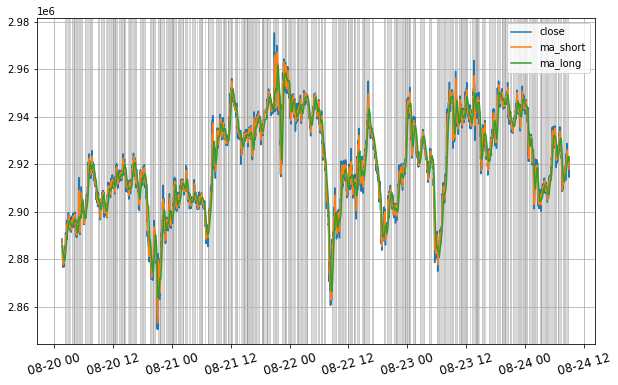

In [49]:
ts = TechnicalSimulation(hold_day=1000)
ts.simulate(df,start_year=2021,end_year=2022)

## 新システム



# 最初にchartをつくる

[3, 4]


In [ ]:
a = pd.Series(list(range(50)))
a.rolling(25).mean()

In [7]:

limit_ = 30
i = 0
price_list = []

while i<limit_:
    i+=1
    last_price = ticker_info()['last']
    price_list.append(last_price)
    # print("price :",last_price) 
    time.sleep(60)


trade_count = 0
profit = 0
total_profit = 0
pos = 'none'
remain_btc = float(balance_info()['info']['btc'])
jpy_before = float(balance_info()['info']['jpy'])
ma_short = 5
ma_long = 25

while True:
    
    
    try:
        
        time.sleep(57)
        price_list.pop(0)
        price_list.append(ticker_info()['last'])
        price_df = pd.Series(price_list)
        short_line = price_df.rolling(ma_short).mean()
        long_line = price_df.rolling(ma_long).mean()
        # print("price_list ",price_list)
        print("short_line :",short_line.tail().tolist())
        print("long_line  :",long_line.tail().tolist())
        index_ = len(price_df) - 1
        buy_flag = is_buyable(short_line,long_line,index_)
        sell_flag = is_sellable(short_line,long_line,index_)
        print("is_buyable",buy_flag)
        print("is_sellable ",sell_flag)
        print("pos ",pos)
        
        
        if pos=='none':

            print(1)            
        # short_line = [ 100, 110, 120, 130, 140]
        # long_line  = [ 110, 112, 119,]
            
            if buy_flag:
                # buy_market() #未実装
                # デモ用
                orderbook = OrderBook()
                sell_nariyuki = orderbook['asks'][0][0]
                index_buy = sell_nariyuki
                pos = 'entry'
                logger.info('buy')
                print(2)
            
            print(3)

            # time.sleep(6)
            
        if pos=='entry':
            # 買えたかどうかチェック
            # is_buy, is_sell = get_status(sell_amount)
            # message = 'is_buy : '+str(is_buy)+' '+'is_sell : '+str(is_sell)
            
            print(4)
            if sell_flag:
                # sell_market() #未実装
                # デモ用
                orderbook = OrderBook()
                buy_nariyuki  = orderbook['bids'][0][0]
                index_sell = buy_nariyuki
                pos = 'none'
                prf = index_sell - index_buy
                total_profit += prf
                logger.info('profit :{0}'.format(prf))
                logger.info('total profit :{0}'.format(total_profit))
                print(5)
                
            print(6)
        # time.sleep(2)
        
    except KeyboardInterrupt:
        logger.info('Finish trade.')
        send_line_notify('Finish')
        break
    
    except Exception as e :
        print(e)
        # エラーが起きた際, ラインに通知が行くようにすると便利
        send_line_notify(e)
        break
    
jpy_after = float(balance_info()['info']['jpy'])
logger.info('Total Profit :{0}'.format(jpy_after-jpy_before))
order_now = OpenOrder()
order_now
# 104727行目　おかしい


short_line : [2259403.2, 2260146.6, 2260860.0, 2261245.4, 2261546.4]
long_line  : [2255891.52, 2256265.56, 2256791.04, 2257182.48, 2257588.84]
is_buyable False
is_sellable  False
pos  none
1
3
short_line : [2260146.6, 2260860.0, 2261245.4, 2261546.4, 2261800.4]
long_line  : [2256265.56, 2256791.04, 2257182.48, 2257588.84, 2257979.48]
is_buyable False
is_sellable  False
pos  none
1
3
short_line : [2260860.0, 2261245.4, 2261546.4, 2261800.4, 2261684.0]
long_line  : [2256791.04, 2257182.48, 2257588.84, 2257979.48, 2258331.04]
is_buyable False
is_sellable  False
pos  none
1
3
short_line : [2261245.4, 2261546.4, 2261800.4, 2261684.0, 2261372.2]
long_line  : [2257182.48, 2257588.84, 2257979.48, 2258331.04, 2258685.16]
is_buyable False
is_sellable  False
pos  none
1
3
short_line : [2261546.4, 2261800.4, 2261684.0, 2261372.2, 2260968.2]
long_line  : [2257588.84, 2257979.48, 2258331.04, 2258685.16, 2258908.64]
is_buyable False
is_sellable  False
pos  none
1
3
short_line : [2261800.4, 2261684.0,

long_line も short_line も \
右肩下がりのとき, 回シグナルでる　そういうときはやめる \
short_line 微分係数 0 の時売却

## データ取得

In [76]:
orderbook = OrderBook()
# 成り行き売り注文だったら約定すると思われる価格
buy_nariyuki  = orderbook['bids'][0][0]
# 成り行き買い注文だったら約定すると思われる価格
sell_nariyuki = orderbook['asks'][0][0]

In [71]:
orderbook['asks']

[[2285086.0, 0.02],
 [2285089.0, 0.02],
 [2285254.0, 0.02],
 [2285283.0, 0.02180626],
 [2285301.0, 0.02432385],
 [2285407.0, 0.1],
 [2285408.0, 0.01],
 [2285438.0, 0.0919],
 [2285524.0, 0.239],
 [2285705.0, 0.011],
 [2285706.0, 0.11],
 [2285821.0, 0.04657416],
 [2285878.0, 0.154],
 [2285938.0, 0.04469],
 [2286114.0, 0.936],
 [2287559.0, 0.05719],
 [2288000.0, 0.005],
 [2288316.0, 0.02275634],
 [2288326.0, 0.02161294],
 [2288385.0, 1.752],
 [2288947.0, 0.02],
 [2289881.0, 0.0227618],
 [2289901.0, 0.27233935],
 [2289998.0, 0.015],
 [2289999.0, 0.005],
 [2290000.0, 1.40614234],
 [2291364.0, 9.618],
 [2291600.0, 0.2],
 [2292000.0, 1.05374092],
 [2292390.0, 0.38191285],
 [2293000.0, 0.1322],
 [2293483.0, 0.2],
 [2293516.0, 0.04],
 [2294998.0, 0.01],
 [2295000.0, 0.005],
 [2295478.0, 0.005],
 [2295508.0, 6.004],
 [2297225.0, 0.2],
 [2297555.0, 0.2],
 [2298800.0, 0.2],
 [2298817.0, 1.0],
 [2298827.0, 3.64],
 [2299000.0, 0.005],
 [2299998.0, 0.015],
 [2299999.0, 0.02],
 [2300000.0, 1.19946],
 

In [67]:
limit_ = 20
i = 0
price_list = []

while i<limit_:
    i+=1
    last_price = ticker_info()['last']
    price_list.append(last_price)
    print("price :",last_price) 
    time.sleep(60)

price : 2399374.0
price : 2399320.0
price : 2398378.0
price : 2398612.0
price : 2399217.0
price : 2398652.0
price : 2398822.0
price : 2398705.0
price : 2399223.0
price : 2399914.0
price : 2398760.0
price : 2398747.0
price : 2398305.0
price : 2398190.0
price : 2398223.0
price : 2396946.0
price : 2395300.0
price : 2395140.0
price : 2395010.0
price : 2393686.0
